# FIN 514 - Project 2 Choice #1 Python Codes_CN
**Spring 2022**

This notebook provides the valuation of Auto Callable Yield Notes Linked to the S&P500® Index due July 21, 2023
Fully and Unconditionally Guaranteed by JPMorgan Chase & Co.

Team members: Ya-Yen,Li(yayenli2) / Wei Ting,Chao(wtchao3) / Yu-Shiuan,Chang(yschang4)

### Part a) Estimated value from Crank-Nicolson Method

### Part b) Volatility Sensitive Analysis

### Part c) Non-linearity Analysis

This notebook provides a simple Explicit Finite Difference Code to value European style options


## Packages and Configurations

The following common packages will be use on this notebook.
* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

# Part a) Estimated value from Crank-Nicolson Method

## Step 1: Set the parameters

In [2]:
jmax = 250        # Number of S steps
imax = 10000      # Number of t steps
S0 = 4577.1       # Original Stock Price (1/18/2022)
sigma = 0.21589   # Annualized (Future) Volatility of Stock Price Returns
r = 0.007555      # Annualized Continously Compounded Risk-free Rate
q = 0.01455       # Continuous Dividend Yield
TM = 549/365      # Time of Maturity Date (7/21/2023)
TFR = 546/365     # Time of Final Review Date (7/18/2023)
SL = 0            # Minimum S value
SU = 2.5*S0       # Maximum S value
CPN = 5.375       # Coupon Payements per month
Trigger = 0.7*S0  # Trigger Barrier

In [3]:
# Review dates for autocall (Final Review Date TFM included)
Review_dates = [90/365, 120/365, 154/365, 181/365, 212/365, 244/365, 273/365, 304/365,
                335/365, 365/365, 399/365, 426/365, 455/365, 485/365, 518/365, 546/365]  

# Payment dates for coupons from T3-T17 (Final Review Date TM NOT included) 
Payment_dates = [93/365, 125/365, 157/365, 184/365, 217/365, 247/365, 276/365, 309/365, 
                 338/365, 370/365,402/365, 429/365, 458/365, 490/365, 521/365]  

# Payment dates for coupons from T1,T2 (no autocall)
CPN_payment_dates = [37/365, 64/365]

In [4]:
# Check for dates

# delta t
dt = TFR / imax 
print(f"dt: {dt}")

# Review dates for autocall (Final Review Date TM included)
ireview1 = [i/dt for i in Review_dates]      
ireview = [int(i) for i in ireview1]     
print(f"ireview:   {ireview}")

# Payment dates for coupons from T3~T17 (Final Review Date TM NOT included) 
ipayment1 = [i/dt for i in Payment_dates]  
ipayment = [int(i) for i in ipayment1]
print(f"ipayment1: {ipayment}")

# Payment dates for coupons from T1,T2 (coupon only date)
icpn1 = [i/dt for i in CPN_payment_dates]      
icpn = [int(i) for i in icpn1]     
print(f"icpn1:     {icpn}")

# Payment dates for all coupons from T1~T17 
itotal = icpn + ipayment
print(f"itotal:    {itotal}")

dt: 0.0001495890410958904
ireview:   [1648, 2197, 2820, 3315, 3882, 4468, 5000, 5567, 6135, 6684, 7307, 7802, 8333, 8882, 9487, 10000]
ipayment1: [1703, 2289, 2875, 3369, 3974, 4523, 5054, 5659, 6190, 6776, 7362, 7857, 8388, 8974, 9542]
icpn1:     [677, 1172]
itotal:    [677, 1172, 1703, 2289, 2875, 3369, 3974, 4523, 5054, 5659, 6190, 6776, 7362, 7857, 8388, 8974, 9542]


## Step 2: Build the Crank-Nicolson method function

In [5]:
def CNFD(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmax, CPN, Review_dates, Payment_dates, CPN_payment_dates):
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AND VT AT ALL STEPS
    V = np.zeros([imax+1, jmax+1])
    VT = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax], D[jmax], alpha[jmax], CN_S[jmax]
    A = np.zeros([jmax+1])
    B = np.zeros([jmax+1])
    C = np.zeros([jmax+1])
    D = np.zeros([jmax+1])
    alpha = np.zeros([jmax+1])
    CN_S = np.zeros([jmax+1])

    # Set up time and S steps
    dt = TFR / imax
    dS = SU/jmax

    # Set up Autocall and Trigger steps
    j0 = int(S0/dS)
    jb = int(Trigger/dS)

    # Review dates for autocall (Final Review Date TM included)
    ireview1 = [i/dt for i in Review_dates]       
    ireview = [int(i) for i in ireview1]    

    # Payment dates for coupons T3~T17 (Final Review Date TM NOT included)
    ipayment1 = [i/dt for i in Payment_dates]         
    ipayment = [int(i) for i in ipayment1]      

    # Payment dates for coupons T1,T2 (coupon only date)
    icpn1 = [i/dt for i in CPN_payment_dates]         
    icpn = [int(i) for i in icpn1]      

    # Payment dates for all coupons T1~T17
    itotal = icpn + ipayment

    ### Grid for VT (Trigger event DOES happan) ###########################################################

    ### At maturity
    # Calculate value at maturity VT[imax,j]
    i = imax 

    for j in range(0, jmax+1):    

        if j >= j0:
            VT[i, j] = (1000 + CPN) *  np.exp(-r *(TM - TFR))
        else:
            VT[i, j] = (1000 * (j*dS/S0) + CPN) *  np.exp(-r *(TM - TFR))

    ### Backward in time
    counter1 = 0   # Counter for remaining coupons
    counter2 = 0   # Counter for next autocall day

    for i in range(imax-1, -1, -1):

        ### On review days
        if i in ireview:    
            ### Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0

            # D[0]=PV(remaining coupons)
            PV_cpn = []        # List to save the dicounted coupons
            remain_cpn = len(itotal) - (ireview.index(i)+2)  # Quantities of remaining coupon
            for k in range(1, remain_cpn):
                PV_cpn.append(CPN * np.exp(-r *(itotal[-k] * dt - i * dt)))  # Append dicounted coupons in the list
            D[0] = sum(PV_cpn) # Sum up the dicounted coupons

            # Regular D[j] values
            # Exclude D[0], D[j0]
            # Also calculate the probabilities A, B and C, and D for each j step
            for j in range(1, j0, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                D2 = -VT[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                D[j] = D1+D2+D3

            ### Upper boundary condition at j0 in matrix terms
            A[j0] = 0
            B[j0] = 1
            C[j0] = 0
            D[j0] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

            ### Start LU decomposition
            alpha[0] = B[0]
            CN_S[0] = D[0]

            # Solve alpha, CN_S only from 1 to j0
            for j in range(1, j0+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]             
            VT[i,j0] = CN_S[j0]/alpha[j0]

            for j in range(j0-1, -1, -1):
                VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

            # Add the coupons at last
            for j in range(j0+1,jmax+1):
                VT[i,j] = (1000+CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

            for j in range(1,j0):
                VT[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

        else:

            ### Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = 0

            # Check if i meet the review dates (T18 not included)
            # D[0]=PV(remaining coupons)
            if (i+1) in itotal:
                counter1 += 1
            if counter1 > 0:
                PV_cpn = []         # List to save the dicounted coupons
                for k in range(1, counter1+1):
                    PV_cpn.append(CPN * np.exp(-r *(itotal[-k] * dt - i * dt)))   # Append dicounted coupons in the list
                D[0] = sum(PV_cpn)  # Sum up the dicounted coupons

            # Regular D[j] values
            # Exclude D[0], D[jmax]
            # Also calculate the probabilities A, B and C, and D for each j step
            for j in range(1, jmax, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                D2 = -VT[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                D[j] = D1+D2+D3

            ### Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0
            if (i+1) in ireview:
                counter2 += 1
            D[jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter2] * dt - i * dt))
            # ireview[-counter2]: time of next autocall         

            ### Start LU decomposition
            alpha[0] = B[0]
            CN_S[0] = D[0]


            # Solve alpha, CN_S other than autocall dates
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]
            VT[i,jmax] = CN_S[jmax]/alpha[jmax]

            for j in range(jmax-1, -1, -1):
                VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

            # Add the coupons at last
            if i in icpn:
                for j in range(1, jmax):
                    VT[i,j] += CPN * np.exp(-r * (itotal[icpn.index(i)] * dt - i * dt))  
                    # Add coupon on only coupon payment days


    ### Grid for V (Trigger event does NOT happan) ###########################################################

    ### At maturity
    # Calculate value at maturity V[imax,j]
    i = imax 

    for j in range(jb, jmax+1):    
        V[i, j] = (1000 + CPN) *  np.exp(-r *(TM - TFR))

    ### Backward in time
    counter3 = 0   # Counter for next autocall day

    #Now go back in time
    for i in range(imax-1, -1, -1):

        ### On review days
        if i in ireview:    
            ### Lower boundary condition at jb in matrix terms
            A[jb] = 0
            B[jb] = 1
            C[jb] = 0
            D[jb] = VT[i, jb]

            # Regular D[j] values
            # Exclude D[jb], D[j0]
            # Also calculate the probabilities A, B and C, and D for each j step
            for j in range(jb+1, j0, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                D[j] = D1+D2+D3

            ### Upper boundary condition at j0 in matrix terms
            A[j0] = 0
            B[j0] = 1
            C[j0] = 0
            D[j0] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

            ### Start LU decomposition
            alpha[jb] = B[jb]
            CN_S[jb] = D[jb]           

            # Solve alpha, CN_S only from 1 to j0
            for j in range(jb+1, j0+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]             
            V[i,j0] = CN_S[j0]/alpha[j0]

            for j in range(j0-1, jb-1, -1):
                V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

            # Add the coupons at last
            for j in range(j0+1,jmax+1):
                V[i,j] = (1000+CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

            for j in range(jb+1,j0):
                V[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))


        else:

            ### Lower boundary condition at jb in matrix terms
            A[jb] = 0
            B[jb] = 1
            C[jb] = 0
            D[jb] = VT[i, jb]

            # Regular D[j] values
            # Exclude D[jb], D[jmax]
            # Also calculate the probabilities A, B and C, and D for each j step
            for j in range(jb+1, jmax, 1):
                A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                D[j] = D1+D2+D3

            ### Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0
            if (i+1) in ireview:
                counter3 += 1
            D[jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter3] * dt - i * dt))
            # ireview[-counter3]: time of next autocall

            ### Start LU decomposition
            alpha[jb] = B[jb]
            CN_S[jb] = D[jb]

            # Solve alpha, CN_S other than autocall dates
            for j in range(jb+1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]
            V[i,jmax] = CN_S[jmax]/alpha[jmax]

            for j in range(jmax-1, jb-1, -1):
                V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

            # Add the coupons at last
            if i in icpn:
                for j in range(jb+1, jmax):
                    V[i,j] += CPN * np.exp(-r * (itotal[icpn.index(i)] * dt - i * dt))  
                    # Add coupon on only coupon payment days
                
    # Replace V with VT when j belows jb
    V[:, 0:jb] = VT[:, 0:jb]

    return V[0, j0]

In [6]:
cnfd = CNFD(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmax, CPN, Review_dates, Payment_dates, CPN_payment_dates)
cnfd

991.2889328748062

# Part b) Volatility Sensitive Analysis

In [7]:
# Volatities from 70~100 moneyness 18 months from pricing notes 
vol = [0.3069,  # moneynes 70
       0.2762,  # moneynes 85
       0.2619,  # moneynes 80
       0.2471,  # moneynes 90
       0.2315,  # moneynes 95
       0.2159]  # moneynes 100 (ATM)

In [8]:
# List to save the value 
value_result = []

# Value with different volatilities
for sigma in vol:
    note_value = CNFD(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmax, CPN, Review_dates, Payment_dates, CPN_payment_dates)
    output = {'Volatility': sigma, 'Value': note_value}
    value_result.append(output)

In [9]:
# Print value with different volatilities
value_result

[{'Volatility': 0.3069, 'Value': 960.8970868055843},
 {'Volatility': 0.2762, 'Value': 969.9662983361139},
 {'Volatility': 0.2619, 'Value': 974.5508526600595},
 {'Volatility': 0.2471, 'Value': 979.587397878838},
 {'Volatility': 0.2315, 'Value': 985.2488131238503},
 {'Volatility': 0.2159, 'Value': 991.2849457730784}]

# Part c) Non-linearity Analysis

In [10]:
def CNFD_1(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmaxmin, jmaxmax, jmaxstep, CPN, Review_dates, Payment_dates, CPN_payment_dates):
    
    # LIST TO SAVE RESULTS
    cnfdb_result = []
    
    # Test different jmax
    for jmax in range(jmaxmin, jmaxmax, jmaxstep):
    
        # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AND VT AT ALL STEPS
        V = np.zeros([imax+1, jmax+1])
        VT = np.zeros([imax+1, jmax+1])

        # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
        # A[jmax], B[jmax], C[jmax], D[jmax], alpha[jmax], CN_S[jmax]
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])

        # Set up time and S steps
        dt = TFR / imax
        dS = SU/jmax

        # Set up Autocall and Trigger steps
        j0 = int(S0/dS)
        jb = int(Trigger/dS)

        # Review dates for autocall (Final Review Date TM included)
        ireview1 = [i/dt for i in Review_dates]       
        ireview = [int(i) for i in ireview1]    

        # Payment dates for coupons T3~T17 (Final Review Date TM NOT included)
        ipayment1 = [i/dt for i in Payment_dates]         
        ipayment = [int(i) for i in ipayment1]      

        # Payment dates for coupons T1,T2 (coupon only date)
        icpn1 = [i/dt for i in CPN_payment_dates]         
        icpn = [int(i) for i in icpn1]      

        # Payment dates for all coupons T1~T17
        itotal = icpn + ipayment

        ### Grid for VT (Trigger event DOES happan) ###########################################################

        ### At maturity
        # Calculate value at maturity VT[imax,j]
        i = imax 

        for j in range(0, jmax+1):    

            if j >= j0:
                VT[i, j] = (1000 + CPN) *  np.exp(-r *(TM - TFR))
            else:
                VT[i, j] = (1000 * (j*dS/S0) + CPN) *  np.exp(-r *(TM - TFR))

        ### Backward in time
        counter1 = 0   # Counter for remaining coupons
        counter2 = 0   # Counter for next autocall day

        for i in range(imax-1, -1, -1):

            ### On review days
            if i in ireview:    
                ### Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0

                # D[0]=PV(remaining coupons)
                PV_cpn = []        # List to save the dicounted coupons
                remain_cpn = len(itotal) - (ireview.index(i)+2)  # Quantities of remaining coupon
                for k in range(1, remain_cpn):
                    PV_cpn.append(CPN * np.exp(-r *(itotal[-k] * dt - i * dt)))  # Append dicounted coupons in the list
                D[0] = sum(PV_cpn) # Sum up the dicounted coupons

                # Regular D[j] values
                # Exclude D[0], D[j0]
                # Also calculate the probabilities A, B and C, and D for each j step
                for j in range(1, j0, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                    D2 = -VT[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                    D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                    D[j] = D1+D2+D3

                ### Upper boundary condition at j0 in matrix terms
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

                ### Start LU decomposition
                alpha[0] = B[0]
                CN_S[0] = D[0]

                # Solve alpha, CN_S only from 1 to j0
                for j in range(1, j0+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]             
                VT[i,j0] = CN_S[j0]/alpha[j0]

                for j in range(j0-1, -1, -1):
                    VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

                # Add the coupons at last
                for j in range(j0+1,jmax+1):
                    VT[i,j] = (1000+CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

                for j in range(1,j0):
                    VT[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

            else:

                ### Lower boundary condition in matrix terms
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                # Check if i meet the review dates (T18 not included)
                # D[0]=PV(remaining coupons)
                if (i+1) in itotal:
                    counter1 += 1
                if counter1 > 0:
                    PV_cpn = []         # List to save the dicounted coupons
                    for k in range(1, counter1+1):
                        PV_cpn.append(CPN * np.exp(-r *(itotal[-k] * dt - i * dt)))   # Append dicounted coupons in the list
                    D[0] = sum(PV_cpn)  # Sum up the dicounted coupons

                # Regular D[j] values
                # Exclude D[0], D[jmax]
                # Also calculate the probabilities A, B and C, and D for each j step
                for j in range(1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -VT[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                    D2 = -VT[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                    D3 = -VT[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                    D[j] = D1+D2+D3

                ### Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                if (i+1) in ireview:
                    counter2 += 1
                D[jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter2] * dt - i * dt))
                # ireview[-counter2]: time of next autocall         

                ### Start LU decomposition
                alpha[0] = B[0]
                CN_S[0] = D[0]


                # Solve alpha, CN_S other than autocall dates
                for j in range(1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]
                VT[i,jmax] = CN_S[jmax]/alpha[jmax]

                for j in range(jmax-1, -1, -1):
                    VT[i,j] = (CN_S[j]-C[j]*VT[i,j+1])/alpha[j]

                # Add the coupons at last
                if i in icpn:
                    for j in range(1, jmax):
                        VT[i,j] += CPN * np.exp(-r * (itotal[icpn.index(i)] * dt - i * dt))  
                        # Add coupon on only coupon payment days


        ### Grid for V (Trigger event does NOT happan) ###########################################################

        ### At maturity
        # Calculate value at maturity V[imax,j]
        i = imax 

        for j in range(jb, jmax+1):    
            V[i, j] = (1000 + CPN) *  np.exp(-r *(TM - TFR))

        ### Backward in time
        counter3 = 0   # Counter for next autocall day

        #Now go back in time
        for i in range(imax-1, -1, -1):

            ### On review days
            if i in ireview:    
                ### Lower boundary condition at jb in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = VT[i, jb]

                # Regular D[j] values
                # Exclude D[jb], D[j0]
                # Also calculate the probabilities A, B and C, and D for each j step
                for j in range(jb+1, j0, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                    D[j] = D1+D2+D3

                ### Upper boundary condition at j0 in matrix terms
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

                ### Start LU decomposition
                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]           

                # Solve alpha, CN_S only from 1 to j0
                for j in range(jb+1, j0+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]             
                V[i,j0] = CN_S[j0]/alpha[j0]

                for j in range(j0-1, jb-1, -1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

                # Add the coupons at last
                for j in range(j0+1,jmax+1):
                    V[i,j] = (1000+CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))

                for j in range(jb+1,j0):
                    V[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))


            else:

                ### Lower boundary condition at jb in matrix terms
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = VT[i, jb]

                # Regular D[j] values
                # Exclude D[jb], D[jmax]
                # Also calculate the probabilities A, B and C, and D for each j step
                for j in range(jb+1, jmax, 1):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                    D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                    D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                    D[j] = D1+D2+D3

                ### Upper boundary condition in matrix terms
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                if (i+1) in ireview:
                    counter3 += 1
                D[jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter3] * dt - i * dt))
                # ireview[-counter3]: time of next autocall

                ### Start LU decomposition
                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]

                # Solve alpha, CN_S other than autocall dates
                for j in range(jb+1, jmax+1, 1):
                    alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                    CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]
                V[i,jmax] = CN_S[jmax]/alpha[jmax]

                for j in range(jmax-1, jb-1, -1):
                    V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]

                # Add the coupons at last
                if i in icpn:
                    for j in range(jb+1, jmax):
                        V[i,j] += CPN * np.exp(-r * (itotal[icpn.index(i)] * dt - i * dt))  
                        # Add coupon on only coupon payment days

        # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Trigger/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Blambda = (jcritB*dS - Trigger)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Barrier Lambda': Blambda}
        cnfdb_result.append(output)

    # return different j results
    return cnfdb_result

### Varying lambda

In [11]:
start_j = 50  # start j (jmaxmin)
end_j = 500   # end j   (jmaxmax)
j_step = 10   # j steps

In [12]:
cnfd_varyLamda = CNFD_1(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, start_j, end_j, j_step, CPN, Review_dates, Payment_dates, CPN_payment_dates)

In [13]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_varyLamda = pd.DataFrame.from_dict(cnfd_varyLamda)

In [14]:
df_varyLamda.head()

,S_steps,t_steps,CN,Barrier Lambda
0,50,10000,992.392730,1.0
1,60,10000,998.004561,0.2
2,70,10000,995.706480,0.4
3,80,10000,993.996013,0.6
4,90,10000,992.683760,0.8


In [15]:
df_varyLamda.tail()

,S_steps,t_steps,CN,Barrier Lambda
40,450,10000,991.200297,1.0
41,460,10000,992.023495,0.2
42,470,10000,991.800017,0.4
43,480,10000,991.587326,0.6
44,490,10000,991.384699,0.8


In [16]:
# EXPORT THE DATA TO A CSV FILE
# df_varyLamda.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project2/cnfd.csv", index=False)

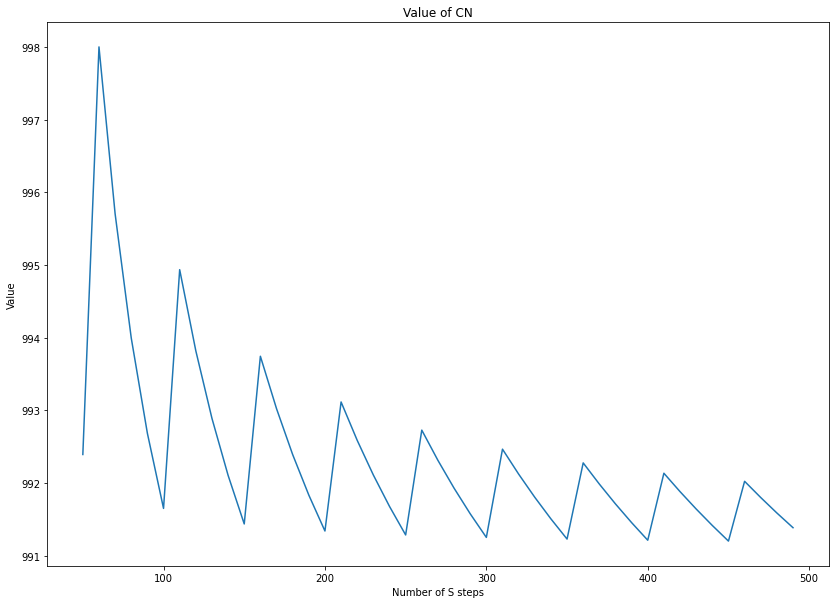

In [17]:
plt.figure(figsize=(14,10))
plt.plot(df_varyLamda['S_steps'], df_varyLamda['CN'], '-', markersize=3)
plt.title("Value of CN")
plt.xlabel("Number of S steps")
plt.ylabel("Value")
# plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project2/cn_value_1.png')
plt.show()

### Lambda=1
In this case, since the continuous barrier (autocall) have the largest error, we can make the grid exactly on the notes,
by selecting lamda=1.

In [18]:
start_j = 50  # start j (jmaxmin)
end_j = 500   # end j   (jmaxmax)
j_step = 25   # j steps

In [19]:
cnfd_lamda1 = CNFD_1(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, start_j, end_j, j_step, CPN, Review_dates, Payment_dates, CPN_payment_dates)

In [20]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_Lamda1 = pd.DataFrame.from_dict(cnfd_lamda1)

In [21]:
df_Lamda1.head()

,S_steps,t_steps,CN,Barrier Lambda
0,50,10000,992.392730,1.0
1,75,10000,991.885130,1.0
2,100,10000,991.650319,1.0
3,125,10000,991.518996,1.0
4,150,10000,991.436248,1.0


In [22]:
df_Lamda1.tail()

,S_steps,t_steps,CN,Barrier Lambda
13,375,10000,991.219479,1.0
14,400,10000,991.212079,1.0
15,425,10000,991.205748,1.0
16,450,10000,991.200297,1.0
17,475,10000,991.195577,1.0


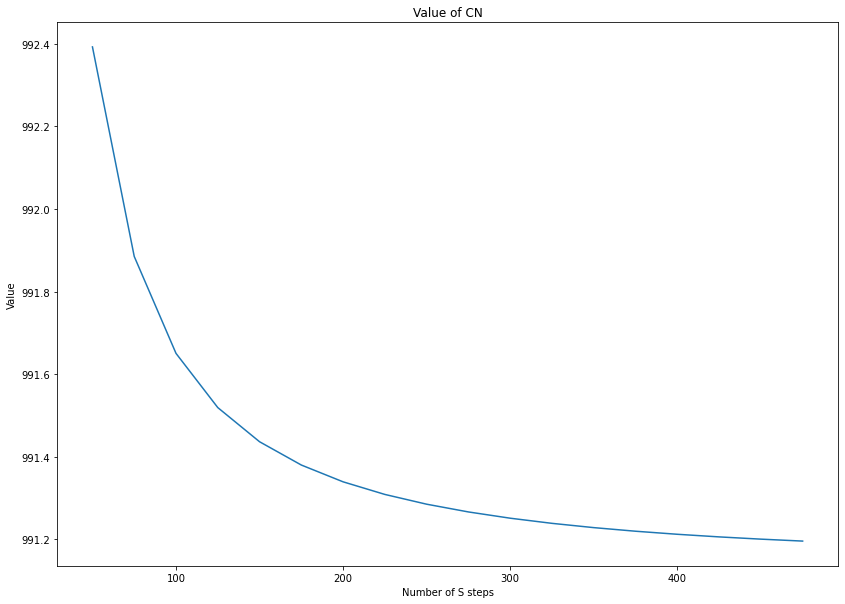

In [23]:
plt.figure(figsize=(14,10))
plt.plot(df_Lamda1['S_steps'], df_Lamda1['CN'], '-', markersize=3)
plt.title("Value of CN")
plt.xlabel("Number of S steps")
plt.ylabel("Value")
# plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project2/cn_value_2.png')
plt.show()